# Install libraries

In [1]:
!pip install scipy
!pip install nevergrad
!pip install numpy

# Set up, check folders, etc

In [2]:
import pandas as pd
from google.colab import files
import os.path
import io

# Check if the file "data.xlsx" or "data.csv" exists
if not (os.path.exists('data.xlsx')):
    uploaded = files.upload()

# Create images folder if it doesn't exist
if not os.path.exists('images'):
    os.makedirs('images')

# Create numerical folder if it doesn't exist
if not os.path.exists('numerical'):
    os.makedirs('numerical')

if os.path.exists('data.xlsx'):
    DATA = pd.read_excel('data.xlsx')
elif os.path.exists('data.csv'):
    DATA = pd.read_csv('data.csv', encoding='windows-1252')
else:
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))

        # If the uploaded file is a CSV, you can load it into a DataFrame like this
        if fn.endswith('.csv'):
            DATA = pd.read_csv(io.StringIO(uploaded[fn].decode('windows-1252')))
        elif fn.endswith('.xlsx'):  # If it's an Excel file
            DATA = pd.read_excel(io.BytesIO(uploaded[fn]))
        else:
            print(f"Unsupported file type: {fn}")
            continue

# Now, DATA is a DataFrame containing the contents of the uploaded or existing file

Saving data.xlsx to data.xlsx


# Check for growth rate column, do data cleaning

In [3]:
if 'growth_rate' in DATA.columns:
    DATA = DATA.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    DATA['growth_rate'] = DATA['growth_rate'].fillna('Not listed')
    DATA['growth_rate'] = DATA['growth_rate'].apply(lambda x: x if x in ["Fast", "Medium", "Slow"] else "Not listed")
    DATA['growth_rate'] = DATA['growth_rate'].replace('NaN', 'Not listed')
    print(DATA)
else:
    print("No 'growth_rate' column found in the DataFrame.")


No 'growth_rate' column found in the DataFrame.


# Visual inspection

## Plot DBH

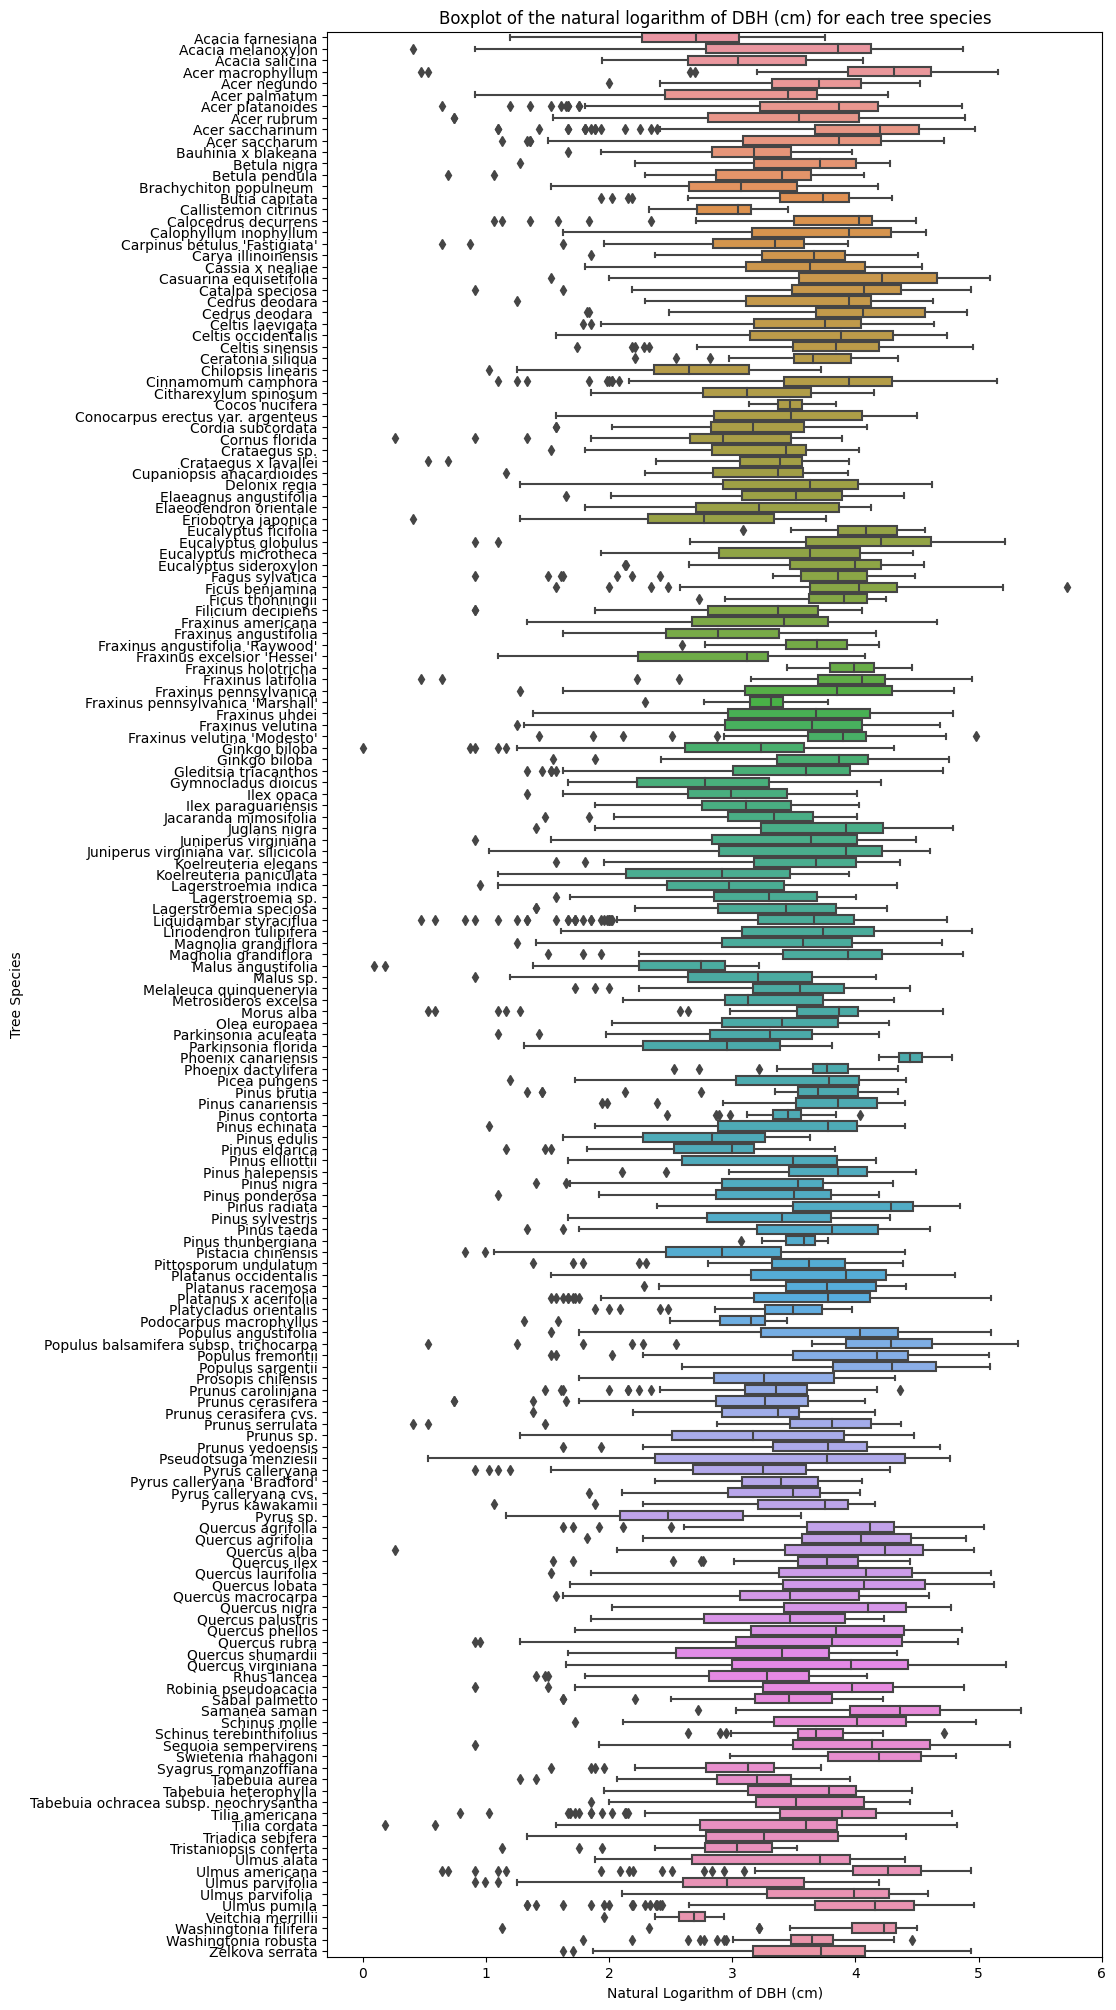

In [5]:
# Import the natural logarithm function
from numpy import log
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore')

# Add a new column for the logarithm of 'dbh'
DATA['log_dbh'] = log(DATA['dbh'])

# Create a boxplot of the logarithm of DBH (cm) for each tree species, color-coded by growth rate if it exists
plt.figure(figsize=(10,25))
if 'growth_rate' in DATA.columns:
    sns.boxplot(y="botanical_names", x="log_dbh", hue="growth_rate", data=DATA, palette=sns.color_palette("Paired"), orient="h")
else:
    sns.boxplot(y="botanical_names", x="log_dbh", data=DATA, orient="h")

plt.title('Boxplot of the natural logarithm of DBH (cm) for each tree species')
plt.ylabel('Tree Species')
plt.xlabel('Natural Logarithm of DBH (cm)')

# Save the plot as a PNG file
plt.savefig("images/log_dbh_boxplot.png")

# Display the plot
plt.show()


## Plot Age

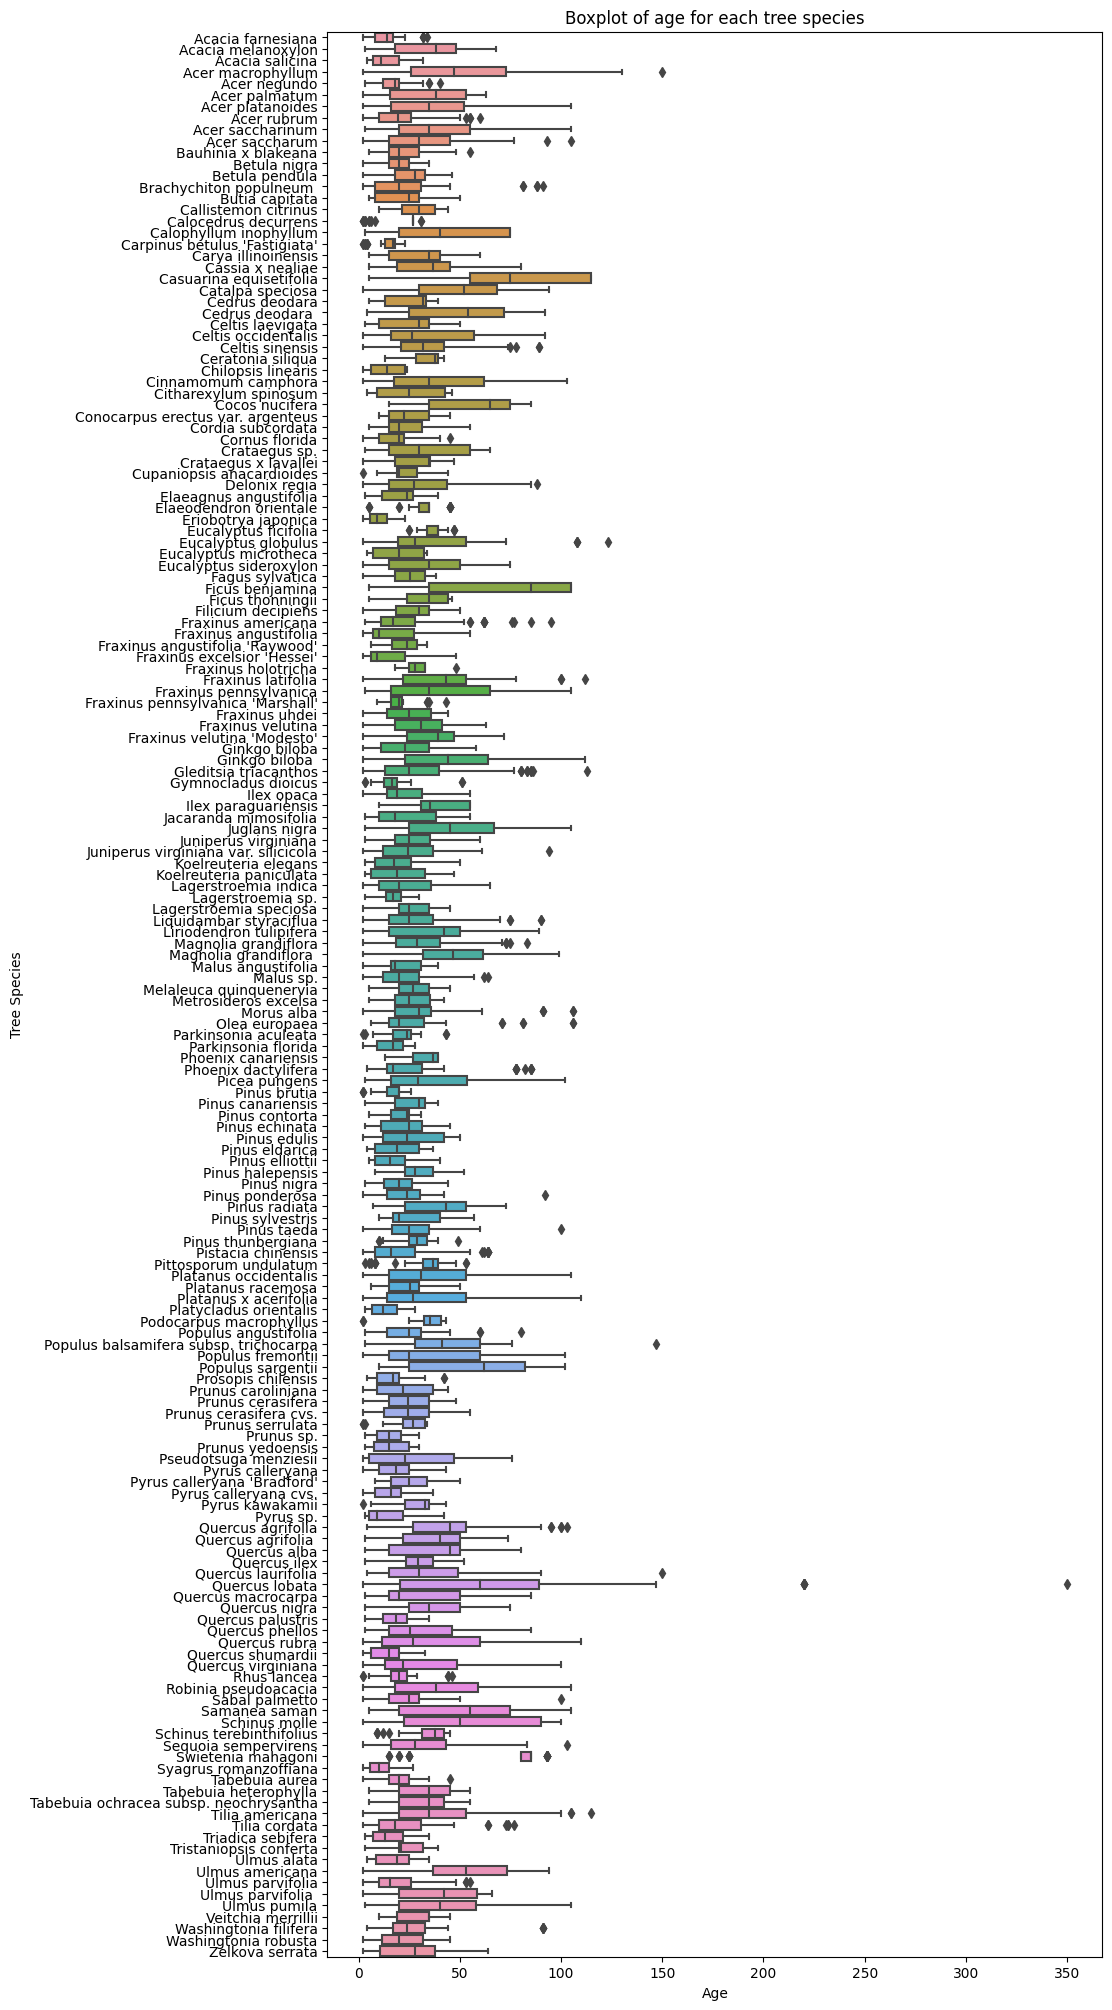

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a boxplot of age for each tree species, color-coded by growth rate (if available)
plt.figure(figsize=(10,25))
if 'growth_rate' in DATA.columns:
    sns.boxplot(y="botanical_names", x="age", hue="growth_rate", data=DATA, palette=sns.color_palette("Paired"), orient="h")
else:
    sns.boxplot(y="botanical_names", x="age", data=DATA, orient="h")

plt.title('Boxplot of age for each tree species')
plt.ylabel('Tree Species')
plt.xlabel('Age')

# Save the plot as a PNG file
plt.savefig("images/age_boxplot.png")

# Display the plot
plt.show()


## Plot Height

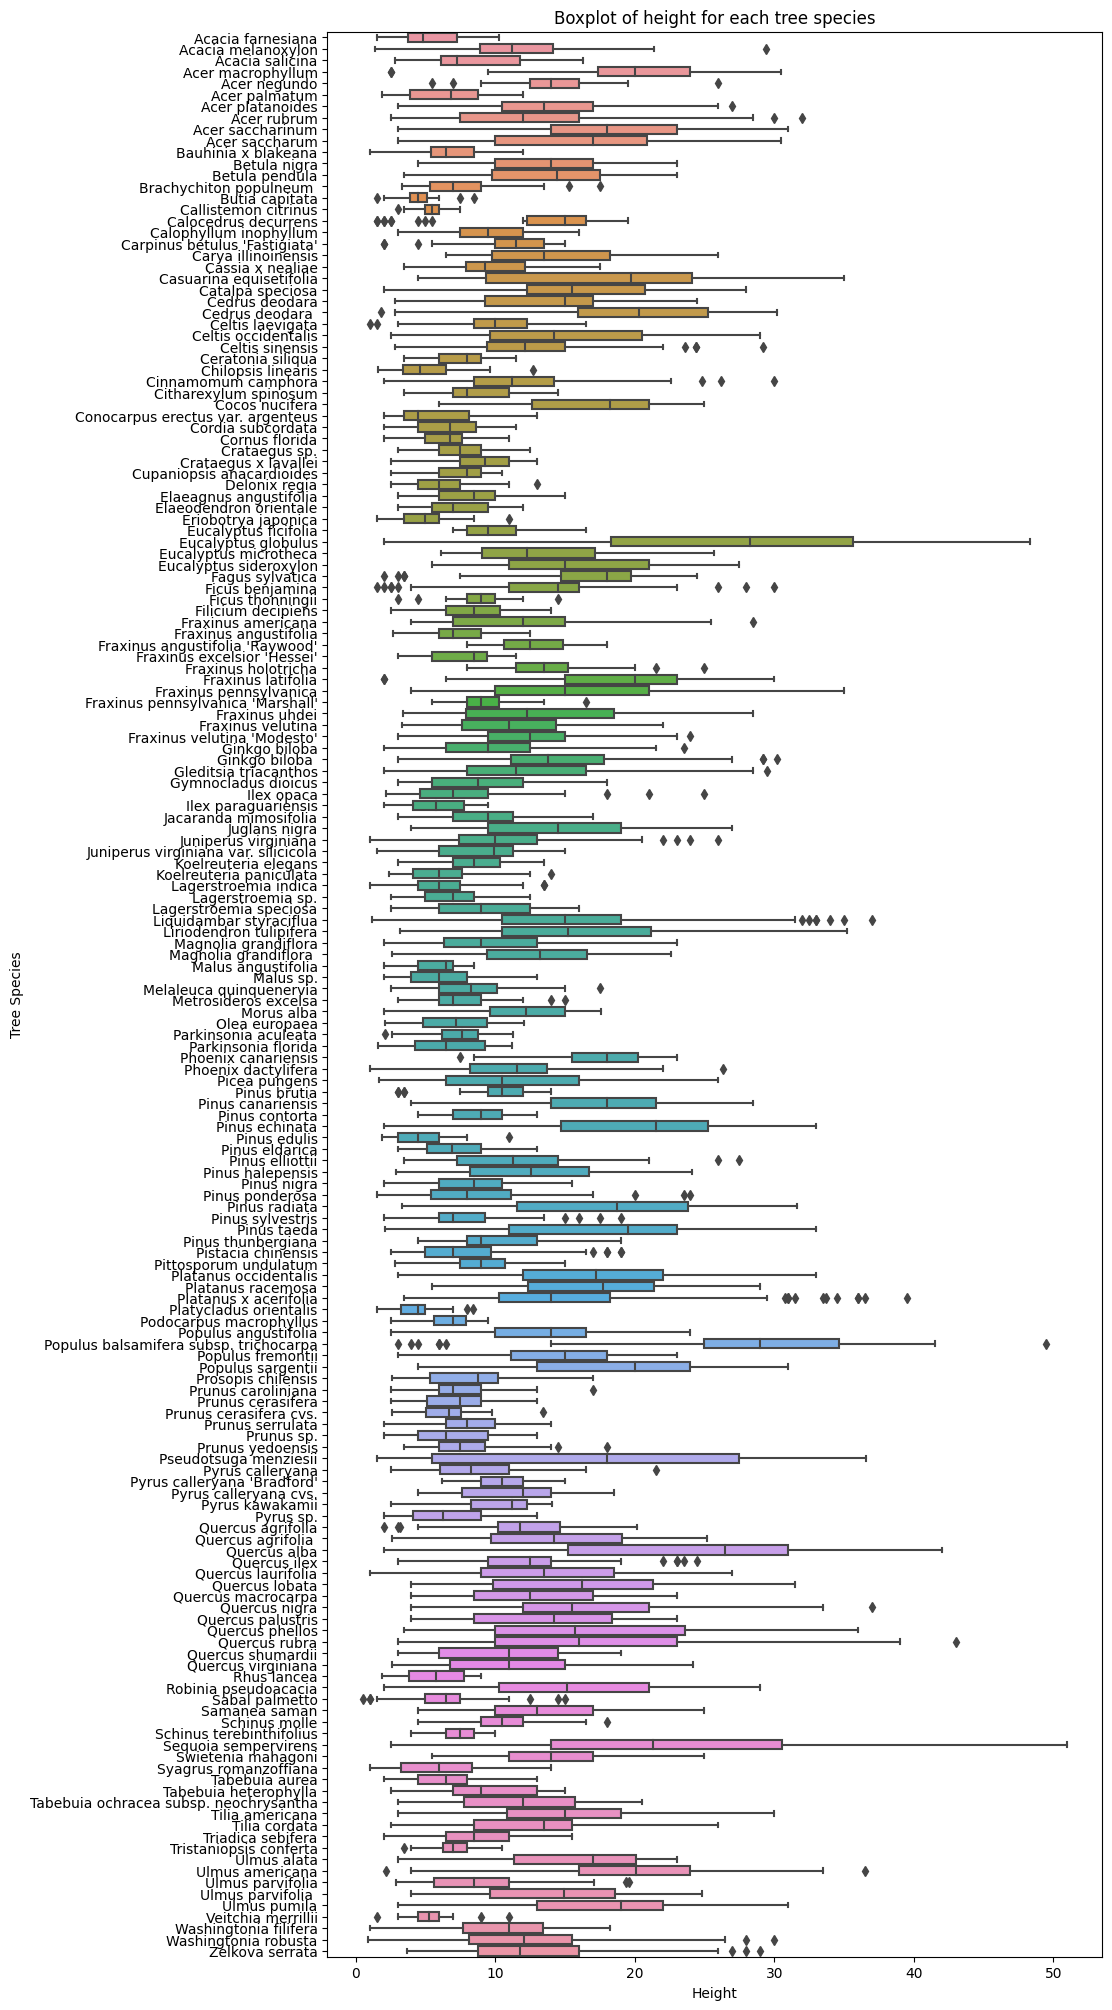

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a boxplot of height for each tree species, color-coded by growth rate (if available)
plt.figure(figsize=(10, 25))
if 'growth_rate' in DATA.columns:
    sns.boxplot(y="botanical_names", x="height", hue="growth_rate", data=DATA, palette=sns.color_palette("Paired"), orient="h")
else:
    sns.boxplot(y="botanical_names", x="height", data=DATA, orient="h")

plt.title('Boxplot of height for each tree species')
plt.ylabel('Tree Species')
plt.xlabel('Height')

# Save the plot as a PNG file
plt.savefig("images/height_boxplot.png")

# Display the plot
plt.show()


# Chapman-Richards function fitting via Nevergrad

species_ranges.csv not found. Falling back to universal parameter ranges.
Starting optimization for all species.

Processing species: acacia farnesiana (1 out of 163)
Optimizing for species: acacia farnesiana
The optimizer selected the NGOpt algorithm.
Nevergrad optimized values for acacia farnesiana - A: 7.2465049919243665, k: 0.0756180827661059, p: 0.47395543873342655


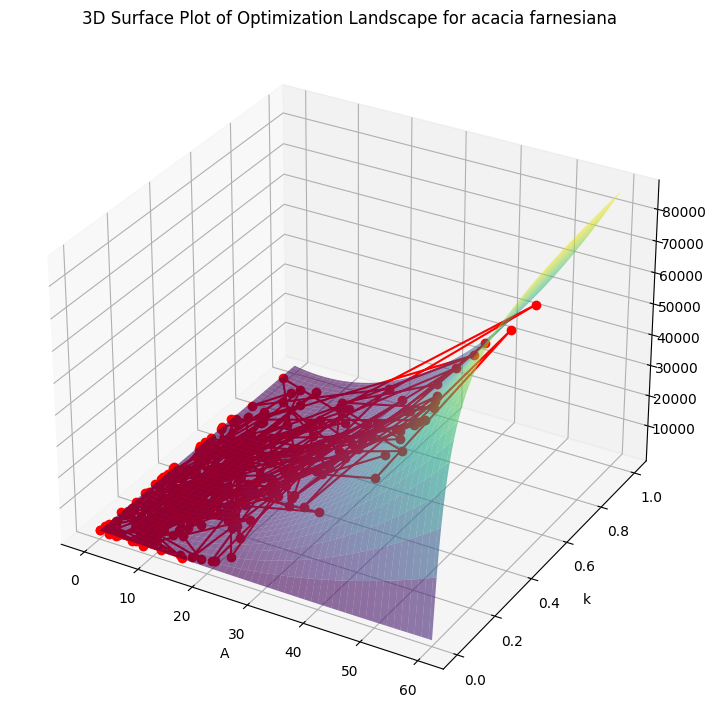


Processing species: acacia melanoxylon (2 out of 163)
Optimizing for species: acacia melanoxylon
The optimizer selected the NGOpt algorithm.
Nevergrad optimized values for acacia melanoxylon - A: 53.960902690887444, k: 0.002531992469914272, p: 0.5835866644978522


In [ ]:
import numpy as np
import scipy as sp
import nevergrad as ng
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mstats
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from sklearn.metrics import mean_squared_error
from scipy.stats import kstest

seed_value = 12321

universal_ranges = {
        'A': (0, 60),
        'k': (0.001, 1),
        'p': (0.1, 3)
        }

# Read the data, winsorize at 99%
DATA = pd.read_excel('data.xlsx', sheet_name='data')
DATA['height'] = mstats.winsorize(DATA['height'], limits=[0, 0.01])
DATA['age'] = mstats.winsorize(DATA['age'], limits=[0, 0.01])

# Load the species ranges:
# species_ranges = pd.read_csv('species_ranges.csv')

def ks_test_score(predicted_values, actual_values):
    residuals = predicted_values - actual_values
    standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
    ks_statistic, _ = kstest(standardized_residuals, 'norm')
    return ks_statistic


def clean_forestry_data(df):
    df = df.applymap(lambda x: x.strip() if type(x) == str else x)
    df.columns = df.columns.str.strip()
    df[['height', 'age', 'dbh']] = df[['height', 'age', 'dbh']].apply(pd.to_numeric, errors='coerce')
    df = df.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
    df = df.applymap(lambda x: x.replace('"', "'") if isinstance(x, str) else x)
    df = df[df['age'] > 1]
    return df

def chapman_richards(age, A, k, p):
    return A * (1 - np.exp(-k * age))**p

def objective(params, species_data, age_col, height_col):
    A, k, p = params
    predicted = chapman_richards(species_data[age_col], A, k, p)
    return np.sum((predicted - species_data[height_col])**2)

def load_species_ranges(species_ranges_df):
    species_ranges = {}
    for _, row in species_ranges_df.iterrows():
        species_name = row['species'].strip()
        species_ranges[species_name] = {
            'A': (row['A_lower'], row['A_upper']),
            'k': (row['k_lower'], row['k_upper']),
            'p': (row['p_lower'], row['p_upper'])
        }
    return species_ranges

def objective_with_metrics(params, species_data, age_col, height_col):
    A, k, p = params
    predicted = chapman_richards(species_data[age_col], A, k, p)

    # Calculate residuals
    residuals = predicted - species_data[height_col]

    # RMSE
    rmse = np.sqrt(np.mean(residuals**2))

    # R-squared
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((species_data[height_col] - np.mean(species_data[height_col]))**2)
    r_squared = 1 - (ss_res / ss_tot)

    # Adjusted R-squared
    n = len(species_data)
    p = 3  # for A, k, p
    adj_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

    # KS test score
    ks_score = ks_test_score(predicted, species_data[height_col])

    return rmse, adj_r_squared, ks_score

def estimate_chapman_richards(data, species_col='botanical_names', age_col='age', height_col='height', output_dir=os.getcwd(), species_ranges_df=None):

    #species_specific_ranges = pd.read_csv('species_ranges.csv')
    if species_ranges_df is not None:
        species_specific_ranges = load_species_ranges(species_ranges_df)
    else:
        species_specific_ranges = {}

    # Fallback to the universal range if a species-specific range isn't provided:
    def get_parameter_range(species, parameter):
        return species_specific_ranges.get(species, {}).get(parameter, universal_ranges[parameter])

    # Fallback to the universal range if a species-specific range isn't provided:
    def get_parameter_range(species, parameter):
        return species_specific_ranges.get(species, {}).get(parameter, universal_ranges[parameter])

    param_results = pd.DataFrame()
    fitted_values = pd.DataFrame()

    print("Starting optimization for all species.")
    total_species = len(data[species_col].unique())
    for idx, species in enumerate(data[species_col].unique(), start=1):
        print(f"\nProcessing species: {species} ({idx} out of {total_species})")
        species_data = data[data[species_col] == species]

        if len(species_data) < 30:
            print(f"Skipping species {species} due to insufficient data.")
            continue

        print(f"Optimizing for species: {species}")

        ranges = {
            'A': get_parameter_range(species, 'A'),
            'k': get_parameter_range(species, 'k'),
            'p': get_parameter_range(species, 'p')
        }

        # Fallback to universal_ranges if species-specific ranges are not available
        if not ranges['A']:
            ranges['A'] = universal_ranges['A']
        if not ranges['k']:
            ranges['k'] = universal_ranges['k']
        if not ranges['p']:
            ranges['p'] = universal_ranges['p']

        if not ranges:
            print(f"Ranges for {species} not found in the species_ranges CSV. Skipping this species.")
            continue

        parametrization = ng.p.Instrumentation(
            A=ng.p.Scalar(lower=ranges['A'][0], upper=ranges['A'][1]),
            k=ng.p.Scalar(lower=ranges['k'][0], upper=ranges['k'][1]),
            p=ng.p.Scalar(lower=ranges['p'][0], upper=ranges['p'][1])
        )
        optimizer = ng.optimizers.NGOpt(parametrization=parametrization, budget=1000)

        path_A = []
        path_k = []
        optimizer_losses = []

        def wrapped_objective(**kwargs):
            A = kwargs['A']
            k = kwargs['k']
            p = kwargs['p']
            loss = objective((A, k, p), species_data, age_col, height_col)

            path_A.append(A)
            path_k.append(k)
            optimizer_losses.append(loss)

            return loss

        try:
            recommendation = optimizer.minimize(wrapped_objective)
            _, recommended_dict = recommendation.value
            best_A, best_k, best_p = recommended_dict['A'], recommended_dict['k'], recommended_dict['p']

            optimizer_type = type(optimizer).__name__
            print(f"The optimizer selected the {optimizer_type} algorithm.")

            # Calculate additional metrics
            rmse, adj_r_squared, ks_score = objective_with_metrics((best_A, best_k, best_p), species_data, age_col, height_col)
            new_row = pd.DataFrame({'species': [species], 'A': [best_A], 'k': [best_k], 'p': [best_p], 'Adj_R2': [adj_r_squared], 'RMSE': [rmse], 'KS_Score': [ks_score]})
            param_results = pd.concat([param_results, new_row], ignore_index=True)

        except Exception as e:
            print(f"Error encountered during optimization for species {species}. Details: {e}")
            continue

        print(f"Nevergrad optimized values for {species} - A: {best_A}, k: {best_k}, p: {best_p}")

        # Create 3D Surface Plot
        num_points = 100
        min_value_A, max_value_A = ranges['A']
        min_value_k, max_value_k = ranges['k']
        fixed_p = recommended_dict['p']

        # Create meshgrid of parameter values
        A_values = np.linspace(min_value_A, max_value_A, num_points)
        k_values = np.linspace(min_value_k, max_value_k, num_points)
        A_grid, k_grid = np.meshgrid(A_values, k_values)

        # Calculate the loss for each combination of parameters
        losses = np.array([objective([A, k, fixed_p], species_data, age_col, height_col) for A, k in zip(np.ravel(A_grid), np.ravel(k_grid))])
        loss_grid = losses.reshape(A_grid.shape)

        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection="3d")

        # Adjust subplot layout to prevent label cutoff
        plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.95)  # Adjust these values as needed
        surf = ax.plot_surface(A_grid, k_grid, loss_grid, cmap="viridis", alpha=0.6)
        ax.plot(path_A, path_k, optimizer_losses, color="red", marker="o")
        ax.set_xlabel("A")
        ax.set_ylabel("k")
        ax.set_zlabel("Loss")
        ax.zaxis.labelpad = 15  # Adjust the label padding
        plt.title(f"3D Surface Plot of Optimization Landscape for {species}")
        plt.show()

    # Saving results to Excel
    if not param_results.empty:
        param_results.to_excel(os.path.join(output_dir, "numerical/parameters.xlsx"), sheet_name='data', index=False)
    else:
        print("No parameter results to save.")

    return param_results, fitted_values

# Finally, place the main script execution under this condition
if __name__ == '__main__':
    species_ranges_path = "species_ranges.csv"  # Replace with the actual path

    # Try to read the species_ranges.csv file; if not present, set species_ranges_df to None
    try:
        species_ranges_df = pd.read_csv(species_ranges_path)
    except FileNotFoundError:
        print("species_ranges.csv not found. Falling back to universal parameter ranges.")
        species_ranges_df = None

    if DATA is not None:
        cleaned_data = clean_forestry_data(DATA)
        results, values = estimate_chapman_richards(cleaned_data, species_ranges_df=species_ranges_df)



# Plot all fitted Chapman-Richards functions

## Plot all

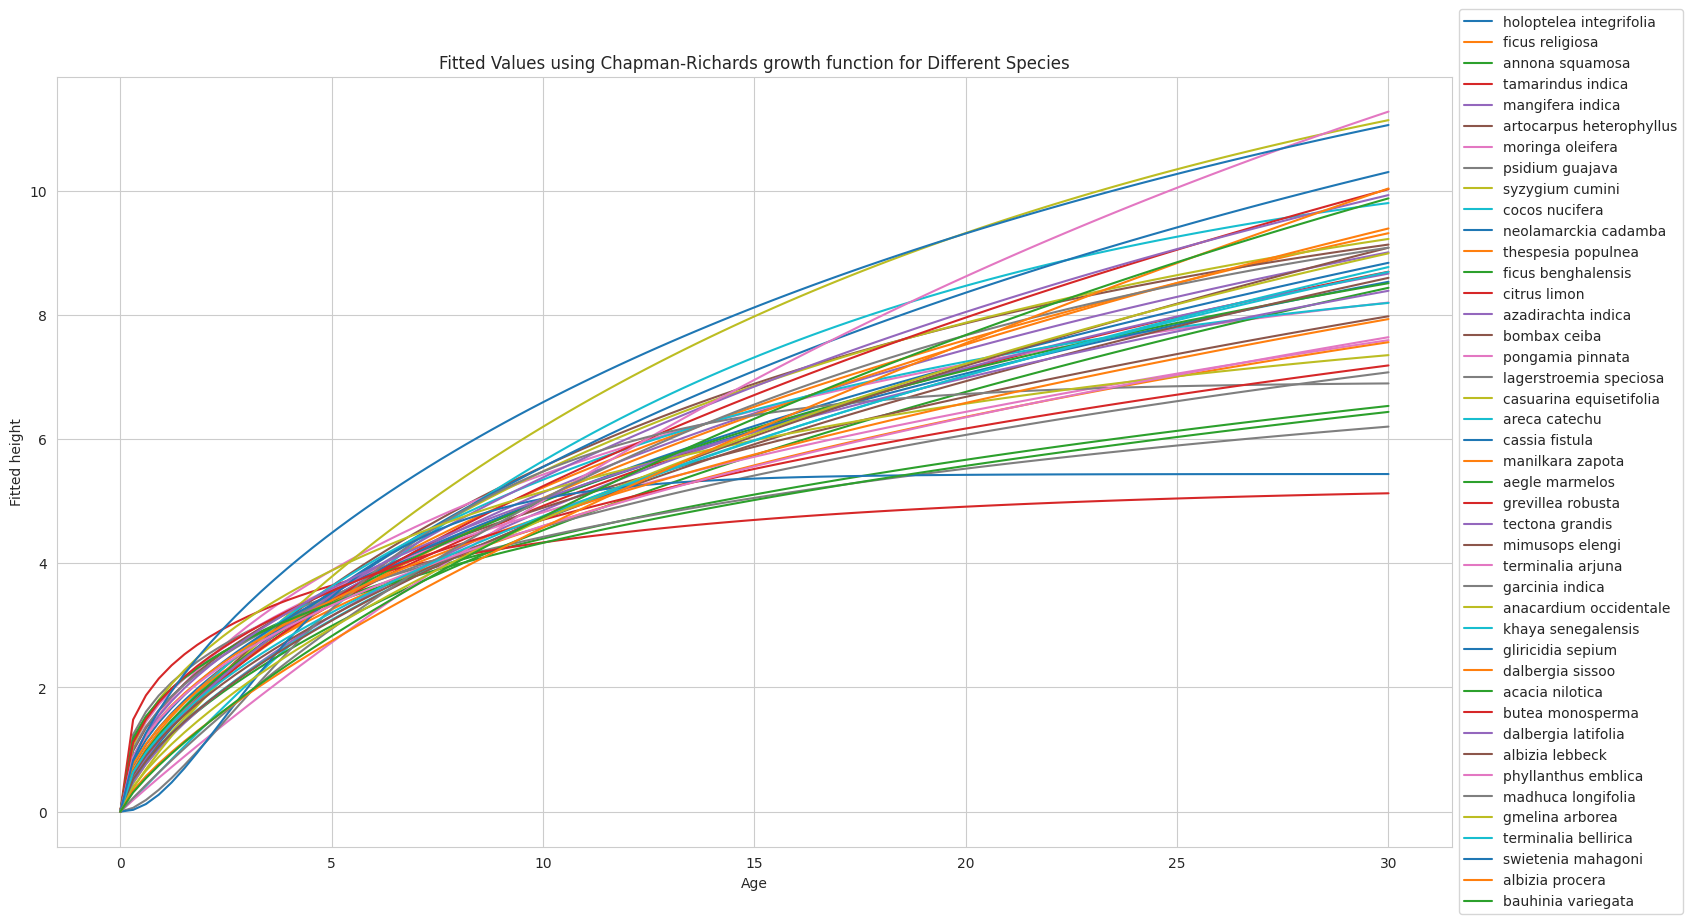

In [26]:
import seaborn as sns
sns.set_style("whitegrid")

def chapman_richards(age, A, k, p):
    return A * (1 - np.exp(-k * age))**p

# Read parameters from Excel file
params_df = pd.read_excel('numerical/parameters.xlsx')

# Create a new figure with a larger size
plt.figure(figsize=(18, 10))

# Define a range of ages for plotting (you can modify as needed)
ages = np.linspace(0, 30, 100)  # Ages from 0 to 30 in 100 steps

# For each species in the parameters file, calculate the growth function and plot
for index, row in params_df.iterrows():
    species = row['species']
    A = row['A']
    k = row['k']
    p = row['p']
    fitted_values = chapman_richards(ages, A, k, p)
    plt.plot(ages, fitted_values, label=species)

# Add labels
plt.xlabel('Age')
plt.ylabel('Fitted height')
plt.title('Fitted Values using Chapman-Richards growth function for Different Species')

# Position the legend outside the plot to the right
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Save the entire figure as a PNG file
plt.savefig('images/fitted_CR_all_species.png')
plt.show()


## Panel widget

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, fixed

# Set the style
sns.set_style("whitegrid")

def chapman_richards(age, A, k, p):
    return A * (1 - np.exp(-k * age))**p

# Read parameters from Excel file
params_df = pd.read_excel('numerical/parameters.xlsx')

# Create an interactive panel using ipywidgets
@interact
def plot_fitted_values(species=params_df['species'], age_range=(0, 60, 1)):
    # Find the row corresponding to the selected species
    selected_species = params_df[params_df['species'] == species]
    if selected_species.empty:
        print("Species not found in the parameters file.")
        return

    # Get parameters for the selected species
    A = selected_species['A'].values[0]
    k = selected_species['k'].values[0]
    p = selected_species['p'].values[0]

    # Define a range of ages for plotting
    ages = np.linspace(0, age_range, 100)

    # Calculate the fitted values using the growth function
    fitted_values = chapman_richards(ages, A, k, p)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(ages, fitted_values, label=species)
    plt.xlabel('Age')
    plt.ylabel('Fitted height')
    plt.title(f'Fitted Values using Chapman-Richards growth function for {species}')
    plt.legend()
    plt.show()


interactive(children=(Dropdown(description='species', options=('holoptelea\xa0integrifolia', 'ficus\xa0religio…

## Age vs Height for Different Species

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def create_species_panel():
    # Load the parameters.xlsx file
    parameters_df = pd.read_excel('numerical/parameters.xlsx')

    # Load your data
    DATA = pd.read_excel('data.xlsx', sheet_name='data')

    # Convert 'botanical_names' to lowercase to match 'species' column in parameters_df
    DATA['botanical_names'] = DATA['botanical_names'].str.lower()

    # Merge data with parameters
    merged_data = DATA.merge(parameters_df, left_on='botanical_names', right_on='species', how='inner')

    # Get unique species
    unique_species = merged_data['botanical_names'].unique()

    # Create widgets
    species_dropdown = widgets.Dropdown(options=unique_species, description='Species:')
    age_slider = widgets.IntRangeSlider(min=0, max=merged_data['age'].max(), step=1, description='Age Range:')
    plot_output = widgets.Output()

    # Define update function
    def update_plot(change):
        selected_species = species_dropdown.value
        age_range = age_slider.value
        plot_output.clear_output()

        with plot_output:
            species_data = merged_data[merged_data['botanical_names'] == selected_species]
            filtered_data = species_data[(species_data['age'] >= age_range[0]) & (species_data['age'] <= age_range[1])]
            age = filtered_data['age']
            height = filtered_data['height']

            n = len(filtered_data)  # Calculate the sample size
            sample_size_text = f'Sample Size (n) = {n}'

            fig, ax = plt.subplots(figsize=(10, 6))
            plt.scatter(age, height, alpha=0.6)
            plt.xlabel('Age')
            plt.ylabel('Height')
            plt.title(f'Age vs Height for {selected_species}')
            plt.text(0.02, 0.95, sample_size_text, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
            plt.grid(True)
            plt.show()

    species_dropdown.observe(update_plot, names='value')
    age_slider.observe(update_plot, names='value')

    # Display widgets
    widget_box = widgets.VBox([species_dropdown, age_slider, plot_output])
    display(widget_box)

# Call the function to create the interactive panel
create_species_panel()


# Fitted heights

In [21]:
import pandas as pd
import numpy as np

# Load the parameters.xlsx file
parameters_df = pd.read_excel('numerical/parameters.xlsx')

# Load your data
DATA = pd.read_excel('data.xlsx', sheet_name='data')

# Convert 'botanical_names' to lowercase to match 'species' column in parameters_df
DATA['botanical_names'] = DATA['botanical_names'].str.lower()

# Merge data with parameters
merged_data = DATA.merge(parameters_df, left_on='botanical_names', right_on='species', how='inner')

# Define the range of ages
ages = np.arange(1, 31)

# Create a dictionary to store the fitted heights
fitted_heights_dict = {'age': [], 'species': [], 'fitted_height': []}

# Calculate and store fitted heights for each age and species
for species in merged_data['botanical_names'].unique():
    species_data = merged_data[merged_data['botanical_names'] == species]
    A = species_data['A'].values[0]
    k = species_data['k'].values[0]
    p = species_data['p'].values[0]

    fitted_heights = A * (1 - np.exp(-k * ages))**p

    for i, age in enumerate(ages):
        fitted_heights_dict['age'].append(age)
        fitted_heights_dict['species'].append(species)
        fitted_heights_dict['fitted_height'].append(fitted_heights[i])

# Create a DataFrame from the dictionary
fitted_heights_df = pd.DataFrame(fitted_heights_dict)

# Save the DataFrame to an Excel file
fitted_heights_df.to_excel('numerical/fitted_heights.xlsx', sheet_name='data', index=False)


## Multi-species comparison selection

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Load the parameters.xlsx file
parameters_df = pd.read_excel('numerical/parameters.xlsx')

# Load your data
DATA = pd.read_excel('data.xlsx', sheet_name='data')

# Convert 'botanical_names' to lowercase to match 'species' column in parameters_df
DATA['botanical_names'] = DATA['botanical_names'].str.lower()

# Merge data with parameters
merged_data = DATA.merge(parameters_df, left_on='botanical_names', right_on='species', how='inner')

# Define the range of ages
ages = np.arange(1, 31)

# Create a dictionary to store the fitted heights
fitted_heights_dict = {'age': [], 'species': [], 'fitted_height': []}

# Calculate and store fitted heights for each age and species
for species in merged_data['botanical_names'].unique():
    species_data = merged_data[merged_data['botanical_names'] == species]
    A = species_data['A'].values[0]
    k = species_data['k'].values[0]
    p = species_data['p'].values[0]

    fitted_heights = A * (1 - np.exp(-k * ages))**p

    for i, age in enumerate(ages):
        fitted_heights_dict['age'].append(age)
        fitted_heights_dict['species'].append(species)
        fitted_heights_dict['fitted_height'].append(fitted_heights[i])

# Create a DataFrame from the dictionary
fitted_heights_df = pd.DataFrame(fitted_heights_dict)

# Save the DataFrame to an Excel file
fitted_heights_df.to_excel('numerical/fitted_heights.xlsx', sheet_name='data', index=False)

# Create widgets
species_selection = widgets.SelectMultiple(
    options=merged_data['botanical_names'].unique(),
    description='Species:',
    rows=5
)
search_text = widgets.Text(
    value='',
    description='Search Species:',
    placeholder='Enter species name',
    layout=widgets.Layout(width='50%')
)
plot_output = widgets.Output()

# Define update function
def update_plot(change):
    selected_species = species_selection.value
    plot_output.clear_output()

    with plot_output:
        fig, ax = plt.subplots(figsize=(10, 6))
        for species in selected_species:
            species_data = fitted_heights_df[fitted_heights_df['species'] == species]
            plt.plot(species_data['age'], species_data['fitted_height'], label=species)

        plt.xlabel('Age')
        plt.ylabel('Fitted Height')
        plt.title('Fitted Heights for Different Species')
        plt.legend()
        plt.grid(True)
        plt.show()

species_selection.observe(update_plot, names='value')

def search_species(change):
    search_term = search_text.value.lower()
    filtered_species = merged_data[merged_data['botanical_names'].str.contains(search_term)]['botanical_names'].unique()
    species_selection.options = filtered_species

search_text.observe(search_species, names='value')

# Display widgets
widget_box = widgets.VBox([search_text, species_selection, plot_output])
display(widget_box)


# Output files

In [ ]:
import datetime

# Get the current datetime to create a unique folder name
current_datetime = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
output_folder_name = f"artemis_{current_datetime}"

# Check the directories
image_folder_path = os.path.join(output_folder_name, 'images')
numerical_folder_path = os.path.join(output_folder_name, 'numerical')
os.makedirs(image_folder_path, exist_ok=True)
os.makedirs(numerical_folder_path, exist_ok=True)

# ZIP and download the files
!zip -r /content/{output_folder_name}.zip /content/{output_folder_name}
from google.colab import files
files.download(f"/content/{output_folder_name}.zip")

# License  and Copyright

ARTEMIS Software License Agreement

**THIS SOFTWARE LICENSE AGREEMENT** ("Agreement") is entered into between **FixedPoint IO Ltd**, a company registered in England with company number 13288661 and its registered office address at 20-22 Wenlock Road, London, England, N1 7GU ("Licensor") and **Climate Impact Partners** ("Licensee").

## 1. Grant of License
Licensor hereby grants to Licensee, and Licensee accepts, a non-exclusive, non-transferable license to use the ARTEMIS software ("Software") solely for internal purposes.

## 2. Ownership
The Software is owned by Licensor and is protected by copyright law. No title to or ownership of the Software is transferred to Licensee. Licensee acknowledges and agrees that the Software and all copies thereof are owned by Licensor, and all rights, title, and interest therein shall remain with Licensor.

## 3. Restrictions
Licensee shall not:
- Make copies of the Software or documentation.
- Sell, lease, license, or sublicense the Software.
- Modify, adapt, merge, or create derivative works based on the Software.
- Reverse engineer, decompile, or disassemble the Software.

## 4. Termination
This Agreement is effective until terminated. Licensor may terminate this Agreement if Licensee breaches any of its terms and conditions. Upon termination, Licensee shall destroy all copies of the Software.

## 5. Disclaimer
The Software is provided "as is" without warranty of any kind. Licensor disclaims all warranties, either express or implied, including but not limited to, implied warranties of merchantability, fitness for a particular purpose, and non-infringement.

## 6. Limitation of Liability
Licensor shall not be liable for any damages, including consequential, incidental, direct, indirect, special, punitive, or other damages arising out of the use or inability to use the Software.

## 7. Governing Law
This Agreement shall be governed by the laws of England and Wales.

## 8. Entire Agreement
This Agreement contains the entire agreement between Licensor and Licensee and supersedes all prior negotiations, understandings, and agreements between the parties.

---

**COPYRIGHT NOTICE:**  
This code was developed by FixedPoint IO Ltd for Climate Impact Partners and remains the intellectual property of FixedPoint IO Ltd. Redistribution or sale, in whole or in part, is strictly prohibited without the express written consent of FixedPoint IO Ltd. By using this code, you accept all responsibilities for its use and will not hold FixedPoint IO Ltd, its employees or officers, liable for damages of any sort. Use of this code for illegal purposes is strictly prohibited.  
For technical inquiries, contact: charles@fixedpoint.io  
(c) 2023 FixedPoint IO Ltd.
